# Esercitazione 6
### Laboratorio di Simulazione Numerica

Il materiale dell'esercitazione sei di LSN è raccolto nella cartella `Lab_06`. Il codice è raccolto nelle cartelle ``, corrispondenti alle quattro consegne dell'esercizio. I risultati presentati in questa relazione sono conservati nella cartella `Results`.

---

Il Jupyter Notebook è organizzato nel modo seguente:
- 6.0 caricamento dei pacchetti e introduzione;
- 6.1 completamento del codice `Monte_Carlo_Ising_1D.cpp/h` con l'aggiunta dei metodi per implementare Metropolis e Gibbs, stima dell'andamento delle grandezze di interesse nel range di temperatura $T\in [0.5,2]$.

## 6.0 - caricamento dei pacchetti e introduzione

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

sns.set_theme(font_scale=1.7, style='whitegrid') 

__NB:__ nel paragrafo seguente ho imposto $\mu_B=1=K_B.$

---

In questa esercitazione utilizziamo un codice nel quale implementiamo un modello di Ising. Quello di Ising è un modello per un magnete, nel quale consideriamo un certo numero di spin $s_i$, con $i=1,..,N$ disposti su un reticolo e potenti assumere valore $+1$ o $-1$. In questa sede, per semplicità, consideriamo un modello monodimensionale. 
Esistono dunque $2^N$ stati possibili per il sistema, ciascuno dei quali avente energia rappresentata dall'hamiltoniana di Ising:

$$ H = -J \sum_{\langle ij \rangle} s_i s_j - B \sum_i s_i, $$ 

dove indichiamo con $J$ l'energia di interazione tra spin __primi vicini__ e $B$ l'eventuale campo magnetico esterno. Noi siamo interessati a stimare il valore di alcune grandezze macroscopiche del magnete: energia interna per spin $U/N$, capacità termica 'media' per sito $C/N$, suscettività termica $\chi$ e magnetizzazione $M$. Lo facciamo considerando un _sistema canonico_, dunque fissando la temperatura del sistema $T\equiv 1/\beta$ e il numero di particelle $N$. Per calcolare i valori medi di tali grandezze è importante definire il peso statistico di Boltzmann per uno stato $\mu$, $p(\mu)$ (in questo caso quello relativo al _sistema canonico_).

Per simulare il reticolo di spin ci serve un algoritmo di campionamento; abbiamo utilizzato due approcci: algoritmo di Metropolis e algoritmo di Gibbs. In entrambi i casi partiamo da una configurazione iniziale degli spin, letta dal file `config.0`. A questo punto selezioniamo in modo casuale uno dei siti del reticolo (ad esempio il $k$-esimo) e 
- __Metropolis:__ si cambia il suo valore ($\pm 1 \to \mp 1$). In termini della notazione introdotta nell'esercitazione precedente, indicando con $\mu$ e $\nu$ rispettivamente lo stato vecchio e lo stato nuovo del sistema si effettua $T(\mu\to\nu)$, tale che sia vero $T(\mu\to\nu)=T(\nu\to\mu)$. La probabilità che questa modifica venga accettata è: $$ A(\mu\to\nu)=\min\biggl[ 1, \frac{T(\nu\to\mu)p(\nu)}{T(\mu\to\nu)p(\mu)} \biggr] = \min\biggl[1, e^{-\beta (E_{\nu}-E_{\nu})} \biggr]. $$ Questa scelta consente di accettare sempre le nuove configuarazioni tali che $\Delta E \leq 0$ e accettare con probabilità $e^{-\beta \Delta E}$ quelle in cui si ha invece $\Delta E > 0$;
- __Gibbs:__ si aggiorna il valore dello spin $k$-esimo in funzione del valore che assumono i suoi prossimi vicini. La probabilità che tale spin venga posto uguale a $\pm 1$ nella nuova configurazione ($\nu$) è data da: $$ p\biggl(s^{\nu}_k\to\pm1|\{ s_j^{\mu} \text{t.c.} j\neq k\}\biggr) = \biggl( 1+\text{exp}\bigl[\mp 2\beta \bigl(J\sum_{n.n.} s_i^{\mu}+h\bigr)\bigr]\biggr)^{-1} $$ Nel campionamento "alla Gibbs", infatti, ciò che si deve stabilire è semplicemente il nuovo valore dello spin e il il cambiamento viene sempre accettato.

Nell'implementazione di entrambi gli algoritmi abbiamo utilizzato delle _periodic boundary conditions_ (PBC), tali che $s_{N+1} = S_1$ e non si presentino problemi legati alla dimensione finita del campione di spin.

---

Gli algoritmi di Metropolis e Gibbs ci consentono di campionare lo spazio delle configurazioni del reticolo e, nel farlo, possiamo effettuare più volte le misure delle grandezze medie a cui siamo interessati. Una volta terminato il processo di campionamento, possiamo utilizzare l'insieme di misure raccolto per stimare definitivamente tali grandezze utilizzando il metodo delle medie a blocchi.

## 6.1 - completamento del codice e stima delle grandezze di interesse per $T\in[0.5,2]$

### Equilibrare il sistema

Come già spiegato nel notebook relativo all'esercitazione cinque, quando si esegue un campionamento utilizzando $M(RT)^2$ è importante equilibrare il sistema. Per farlo, si eseguono "a vuoto" $N_{equi}$ passi dell'algoritmo, i quali non vengono coinvolti nella stima delle grandezze. In questo codice ho implementato la fase di equilibrazione all'interno del metodo `Equilibrate_system(int Nequi)`, dove `Nequi` è il numero di passi con cui intendiamo equilibrare il sistema.

---

### I due tipi di campionamento

All'interno del codice le mosse con cui eseguiamo il campionamento sono implementate nel metodo `Move(int metro)`. A seconda del valore fornito tramite la variabile `metro` vengono eseguiti campionamenti tramite Metropolis (`metro = 0`) o Gibbs (`metro = 1`). Questo valore viene letto dal file `input.file`.

In [2]:
ene = np.loadtxt("Results/ene_100_blocks.0")
len(ene)

100

In [3]:
T = 2.0
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )
x_mean = np.linspace(0,np.max(ene.T[0]))
y_mean = x_mean*0 + e 

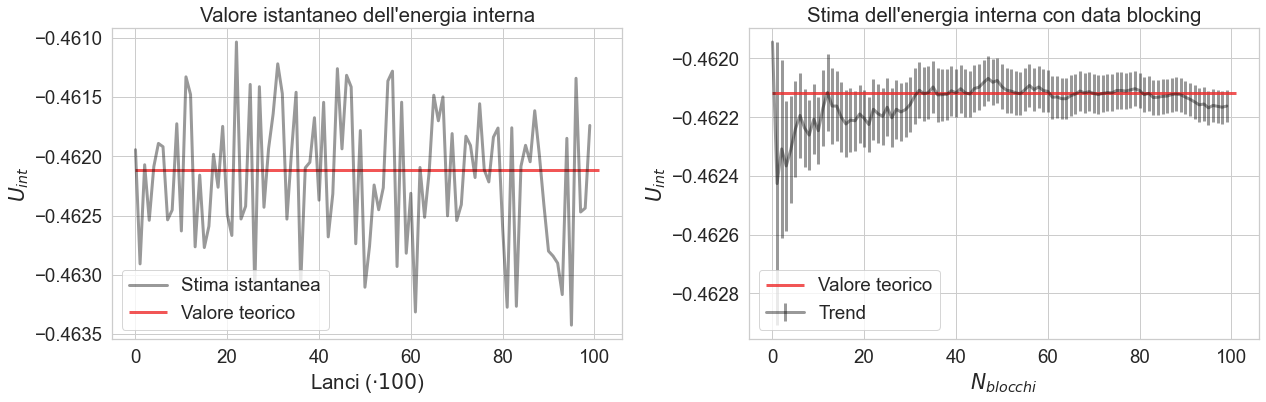

In [4]:
x = np.arange(100)

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.title("Valore istantaneo dell'energia interna")
plt.plot(ene.T[1], color='black', alpha=0.4, linewidth=3, label='Stima istantanea')
plt.hlines(e,0,101, color='#EE2C2C', linewidth=3, alpha=0.8, label='Valore teorico')
plt.xlabel('Lanci ($\cdot 100$)')
plt.ylabel('$U_{int}$')
plt.legend()

plt.subplot(1,2,2)
plt.title("Stima dell'energia interna con data blocking")
plt.errorbar(x, ene.T[2], yerr=ene.T[3], color='black', alpha=0.4, label='Trend', linewidth=3)
plt.hlines(e,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
plt.ylabel("$U_{int}$")
plt.xlabel("$N_{blocchi}$")
plt.legend()
plt.tight_layout()

plt.show()

In [34]:
ene_metro  = np.loadtxt("Results/ene_metro.0")
#ene_metro  = np.loadtxt("output.ene.0")
heat_metro = np.loadtxt("Results/heat_metro.0")
chi_metro  = np.loadtxt("Results/chi_metro.0")
ene_gibbs  = np.loadtxt("Results/ene_gibbs.0")
heat_gibbs = np.loadtxt("Results/heat_gibbs.0")
chi_gibbs  = np.loadtxt("Results/chi_gibbs.0")
M_metro    = np.loadtxt("Results/MAGMET.0")
M_gibbs    = np.loadtxt("Results/MAGGIBBS.0")


G = np.loadtxt("Results/MAGGIBBS.0")
M = np.loadtxt("Results/MAGMET.0")

xx = np.arange(151)

In [21]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

T = np.linspace(0.5,2.0,num=151)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )

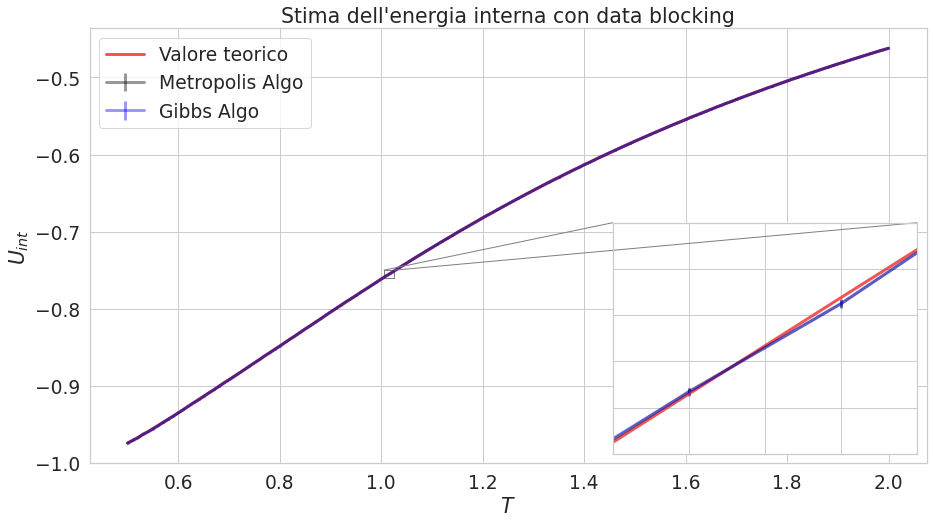

In [157]:
fig, ax = plt.subplots(figsize=[15, 8])
plt.title("Stima dell'energia interna con data blocking")
plt.ylabel("$U_{int}$")
plt.xlabel("$T$")

x1, x2, y1, y2 = 1.005, 1.025, -0.76,-0.75
axins = zoomed_inset_axes(ax, zoom=30, loc=4)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)

ax.plot(T, e, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
axins.plot(T, e, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
ax.errorbar(T, ene_metro.T[2], yerr=ene_metro.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
axins.errorbar(T, ene_metro.T[2], yerr=ene_metro.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
ax.errorbar(T, ene_gibbs.T[2], yerr=ene_gibbs.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')
axins.errorbar(T, ene_gibbs.T[2], yerr=ene_gibbs.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')

mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

ax.legend()
plt.show()

In [136]:
heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)

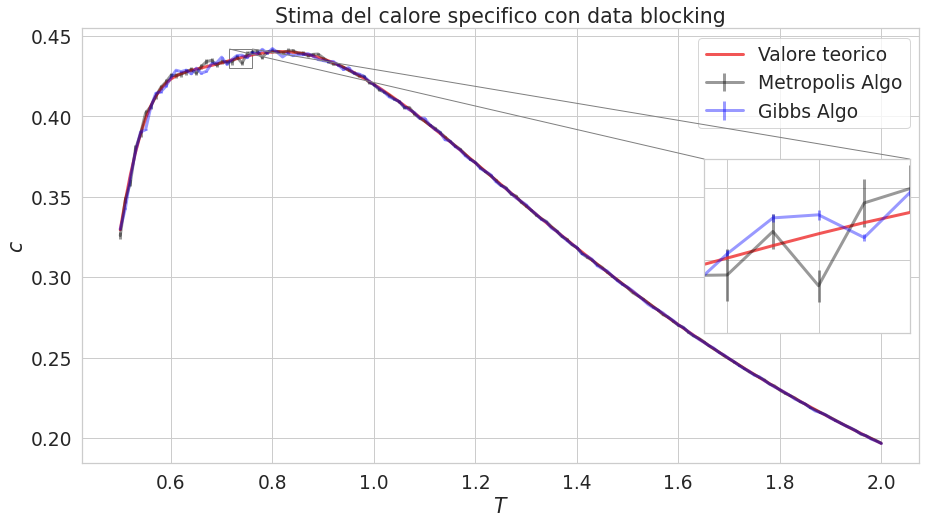

In [147]:
fig, ax = plt.subplots(figsize=[15, 8])
plt.title("Stima del calore specifico con data blocking")
plt.ylabel("$c$")
plt.xlabel("$T$")

x1, x2, y1, y2 = 0.715, 0.76, 0.43, 0.442
axins = zoomed_inset_axes(ax, zoom=9, loc=5)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)

ax.plot(T, heat, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
axins.plot(T, heat, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
ax.errorbar(T, heat_metro.T[2], yerr=heat_metro.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
axins.errorbar(T, heat_metro.T[2], yerr=heat_metro.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
ax.errorbar(T, heat_gibbs.T[2], yerr=ene_gibbs.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')
axins.errorbar(T, heat_gibbs.T[2], yerr=ene_gibbs.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')

mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

ax.legend()
plt.show()

In [130]:
chi = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)
#chi_gibbs

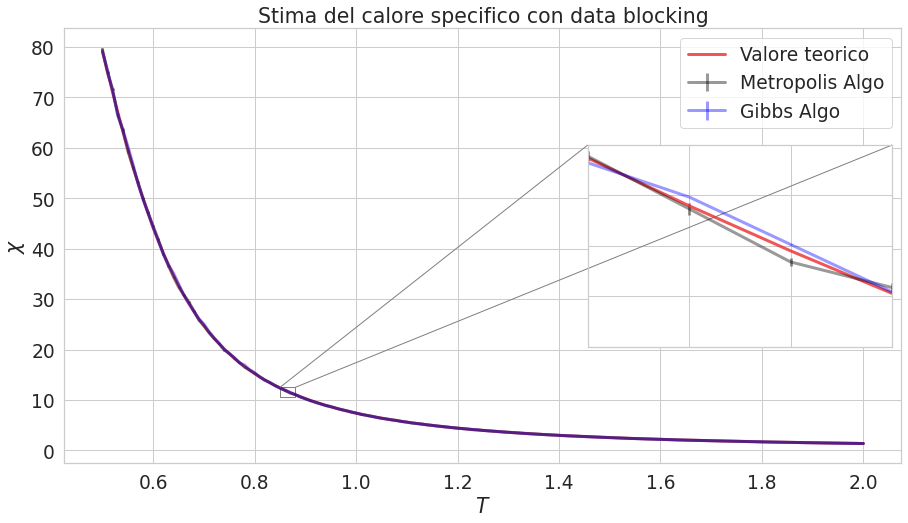

In [217]:
fig, ax = plt.subplots(figsize=[15, 8])
plt.title("Stima del calore specifico con data blocking")
plt.ylabel("$\chi$")
plt.xlabel("$T$")
#plt.errorbar(T, ene_G.T[2], yerr=ene_G.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')

x1, x2, y1, y2 = 0.85, 0.88, 10.5, 12.5
axins = zoomed_inset_axes(ax, zoom=20, loc=5)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)

ax.plot(T, chi, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
axins.plot(T, chi, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
ax.errorbar(T, chi_metro.T[2], yerr=chi_metro.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
axins.errorbar(T, chi_metro.T[2], yerr=chi_metro.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
ax.errorbar(T, chi_gibbs.T[2], yerr=ene_gibbs.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')
axins.errorbar(T, chi_gibbs.T[2], yerr=ene_gibbs.T[3], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')

mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

ax.legend()
plt.show()

In [37]:
# Soluzione analitica
h=0.02 # Campo esterno
b = 1/T

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns

M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

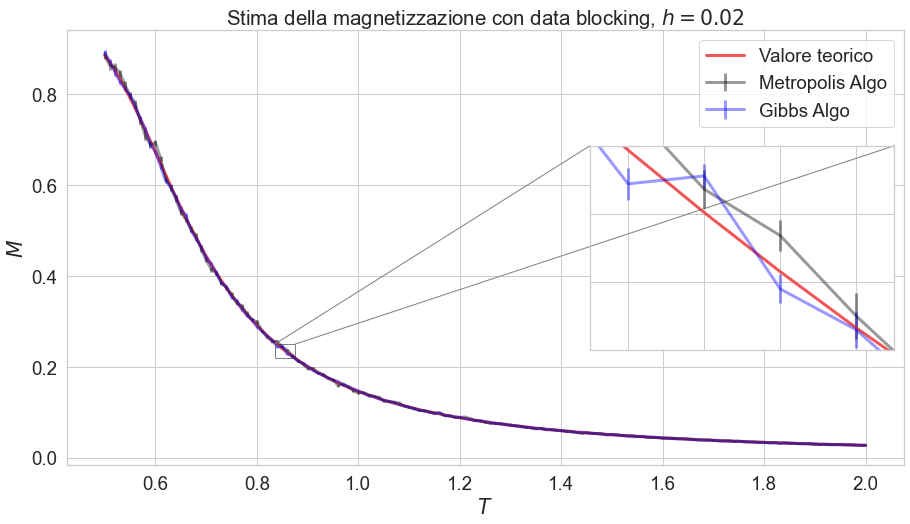

In [38]:
fig, ax = plt.subplots(figsize=[15, 8])
plt.title("Stima della magnetizzazione con data blocking, $h=0.02$")
plt.ylabel("$M$")
plt.xlabel("$T$")

x1, x2, y1, y2 = 0.835, 0.875, 0.22, 0.25
axins = zoomed_inset_axes(ax, zoom=15, loc=5)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)

ax.plot(T, M, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
axins.plot(T, M, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
ax.errorbar(T, M_metro.T[2], yerr=M_metro.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
axins.errorbar(T, M_metro.T[2], yerr=M_metro.T[3], color='black', alpha=0.4, linewidth=3, label='Metropolis Algo')
ax.errorbar(T, M_gibbs.T[2][151:], yerr=M_gibbs.T[3][151:], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')
axins.errorbar(T, M_gibbs.T[2][151:], yerr=M_gibbs.T[3][151:], color='blue', alpha=0.4, linewidth=3, label='Gibbs Algo')

mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

ax.legend()
plt.show()